In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

from pinn import gradient, PINN, Trainer
import scipy

# Damped harmonic oscillator

$$m\frac{d^2 u}{dt^2} + \mu\frac{du}{dt} + ku = 0$$

Initial conditions:

$$u(0) = 1, \frac{du}{dt}(0) = 0$$

In [13]:
def solution(t, d, w0):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    u = 2*A*np.exp(-d*t)*2*A*np.cos(phi + w*t)
    return u

In [84]:
## Hyperparameters
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_epochs = 40000
learning_rate = 1e-2
layers = [1, 32, 32, 1]

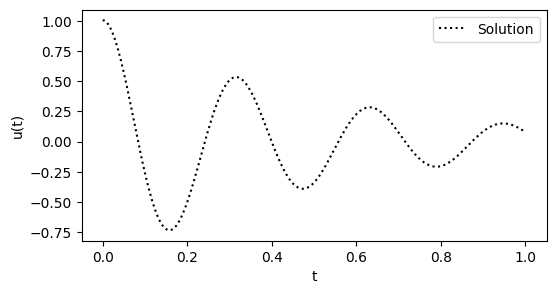

In [85]:
# Data
d, w0 = 2, 20
mu, k = 2 * d, w0**2

t_test_np = np.linspace(0, 1, 300)
t_test = torch.from_numpy(t_test_np).float().view(-1, 1).to(device)
u_sol = solution(t_test_np, d, w0)

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(t_test_np, u_sol, 'k:', label='Solution')
ax.set_xlabel('t')
ax.set_ylabel('u(t)')
ax.legend()
plt.show()

In [86]:
# Modeling and Training
model = PINN(layers_dim=layers, activation="tanh").to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

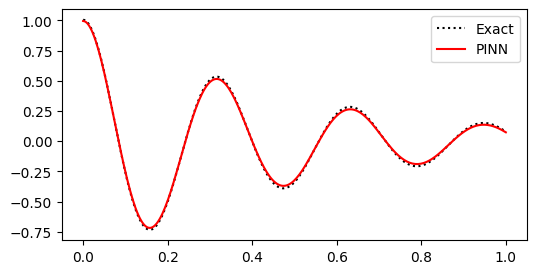

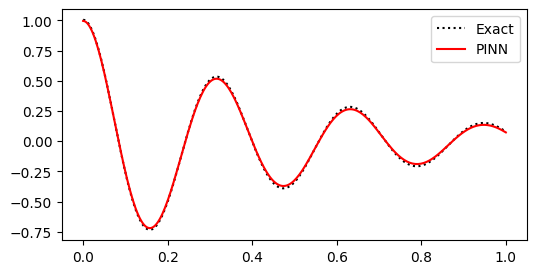

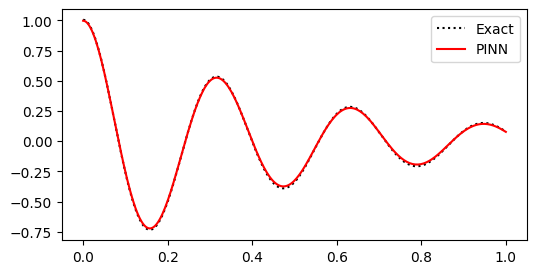

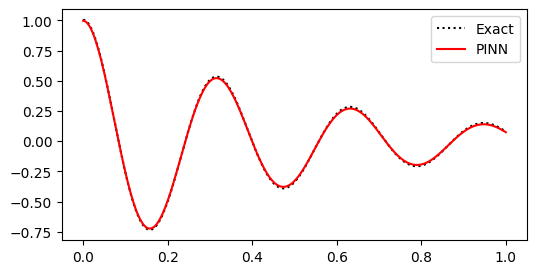

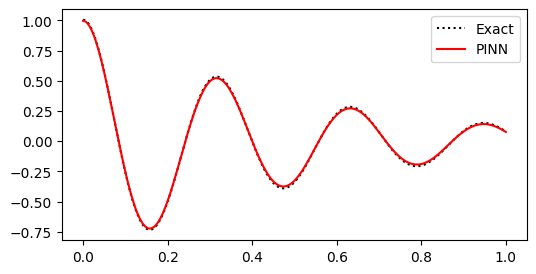

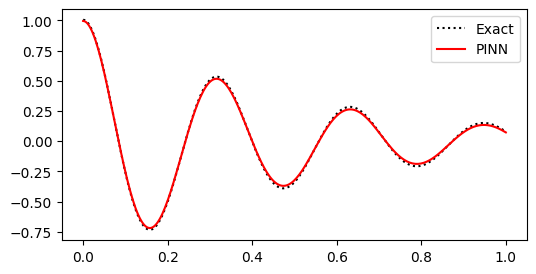

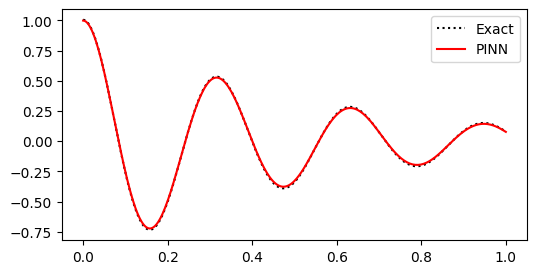

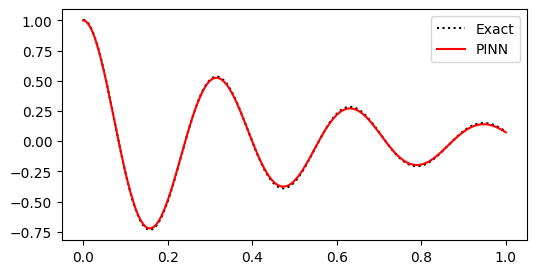

In [87]:
t_boundary = torch.tensor(0.0).view(-1, 1).requires_grad_(True).to(device)
t_physics = torch.linspace(0, 1, 101).view(-1, 1).requires_grad_(True).to(device)

n_epochs = 40000
for i in range(1, n_epochs + 1):

    lambda1, lambda2 = 1e-1, 1e-4
    # lambda1, lambda2 = 1, 1
    
    u = model(t_boundary)
    dudt = gradient(u, t_boundary)
    loss1 = (u - 1)**2
    loss2 = (dudt - 0)**2
   
    u = model(t_physics)
    dudt = torch.autograd.grad(u, t_physics, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, grad_outputs=torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu * dudt + k * u)**2)

    loss = loss1 + lambda1*loss2 + lambda2*loss3
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 5000 == 0:
        u = model(t_test).detach().cpu().numpy().flatten()
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(t_test_np, solution(t_test_np, d, w0), "k:", label="Exact")
        ax.plot(t_test_np, u, "r", label="PINN")
        ax.legend()
        plt.show()
